In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

#from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

#init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Data Loading

In [2]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.7
windowSize = 25

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
import math
import random

In [6]:
# TODO ta metoda modyfikuje dane, a może nie powinna?
# TODO w zbiorze wynikowym moga pojawic sie duplikaty
# TODO przez to, że część danych jest odrzucana, faktyczny testRatio będzie zwykle sporo mniejszy
def spitTrainTestSet2(X, y, testRatio, testSquareSize):
    number_of_pixels = X.shape[0] * X.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
    #for i in range(test_squares_count_floor):
        y_coord = random.randint(0,X.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0,X.shape[1] - testSquareSize - 1) #poziom
        #ten if ma zahardkodowane 20, czyli teraz nigdy do niego nie wejdzie. Zachowanie może i ok, ale trzeba usunac duplikaty z wynikowego zbiotu testowego
        if y[y_coord, x_coord] == 20 or y[y_coord + testSquareSize, x_coord] == 20 or y[y_coord, x_coord + testSquareSize] == 20 or y[y_coord + testSquareSize, x_coord + testSquareSize] == 20:
            failures = failures + 1
        else:
            test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
            test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
            y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 0 #20
            i += 1

    print(failures)
    return test_squares_count_floor, test_squares, test_squares_labels, y

In [7]:
def spitTrainTestSet3(X, y, testRatio, testSquareSize, markTestSquaresAsBg = True):
    y_copy = np.copy(y)
    number_of_pixels = X.shape[0] * X.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
        y_coord = random.randint(0,X.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0,X.shape[1] - testSquareSize - 1) #poziom
        if y[y_coord, x_coord] == 100 or y[y_coord + testSquareSize, x_coord] == 100 or y[y_coord, x_coord + testSquareSize] == 100 or y[y_coord + testSquareSize, x_coord + testSquareSize] == 100:
            failures = failures + 1
            if failures == 1000 or failures == 3000:
                print(failures)
            if failures == 5000:
                y = y_copy
                raise NameError('Hello there')
        else:
            test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
            test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
            y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 100
            i += 1

    print(failures)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i,j] == 100 and markTestSquaresAsBg:
                y[i,j] = 0
    return test_squares_count_floor, test_squares, test_squares_labels, y

In [8]:
def countClassesInLabelSquares(classesCount, labelSquares, margin):
    classes_in_squares = np.zeros((classesCount))
    for i in range(labelSquares.shape[0]):
        for j in range(margin, labelSquares.shape[1] - margin):
            for k in range(margin, labelSquares.shape[2] - margin):
                c = int(labelSquares[i, j, k])
                classes_in_squares[c] += 1
    return classes_in_squares 

In [9]:
#can be merged with above
def countClassesInGt(classesCount, gt):
    classes_in_gt = np.zeros((classesCount))
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            c = int(gt[i, j])
            classes_in_gt[c] += 1
    return classes_in_gt 

In [10]:
def convertSquaresToTestSets(testSquares, testLabelSquares, resultWindowSize, classesInSquares): #resultWindowSize should be odd
    margin = int((resultWindowSize - 1) / 2)
    testCount = int(classesInSquares)
    testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                if testLabelSquares[i, j, k] != 0:
                    testCount -= 1
                    testSet[testCount] = testSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1,:]
                    testSetLabels[testCount] = testLabelSquares[i, j, k]
                    testSet_GT[testCount] = testLabelSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1]
    
    return testSet, testSetLabels, testSet_GT

In [11]:
def convertSquaresToTestSetsAndTreatBackgroundAsClass(testSquares, testLabelSquares, resultWindowSize): #resultWindowSize should be odd
    margin = int((resultWindowSize - 1) / 2)
    testCount = testLabelSquares.shape[0] * testLabelSquares.shape[1] * testLabelSquares.shape[2]
    testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                testCount -= 1
                testSet[testCount] = testSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1,:]
                testSetLabels[testCount] = testLabelSquares[i, j, k]
                testSet_GT[testCount] = testLabelSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1]
    
    return testSet, testSetLabels, testSet_GT

In [12]:
def countPixelsOtherThanValue(gt, value):
    count = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if gt[i, j] != value:
                count += 1
    return count

In [13]:
def countBackgroundPixels(labels):
    count = 0
    for i in range(labels.shape[0]):
        if labels[i] == 0:
            count += 1
    return count

In [14]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [15]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [16]:
def createImageCubes(X, y, windowSize=5, treatBgAsClass = False):
    notIncludedPixelValue = 100 if treatBgAsClass else 0 #look to func when squares are selected split3
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    #patchesData = np.memmap('test.mymemmap', dtype='float32', mode='w+', shape=(X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesData = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue), windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue)))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            if y[r-margin, c-margin] != notIncludedPixelValue:
                patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData[patchIndex, :, :, :] = patch
                patchesLabels[patchIndex] = y[r-margin, c-margin]
                patchIndex = patchIndex + 1

    return patchesData, patchesLabels

In [17]:

                        #################### <--- REAL FUN STARTS HERE ---> ####################


(610, 340, 103) (610, 340)


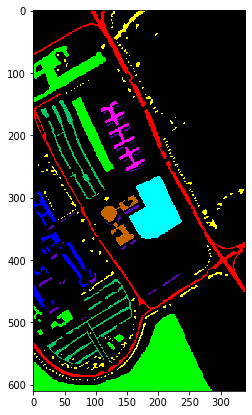

In [21]:
X, y = loadData(dataset)

print(X.shape, y.shape)

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [22]:
K = 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 15)

In [23]:
testSquaresCount, testSquares, testSquares_GT, y = spitTrainTestSet3(X, y, 0.50, windowSize + 15)
#testSquaresCount, testSquares, testSquares_GT, y = spitTrainTestSet2(X, y, 1, windowSize + 10)
testSquares.shape

1000
3000
3402


(64, 40, 40, 15)

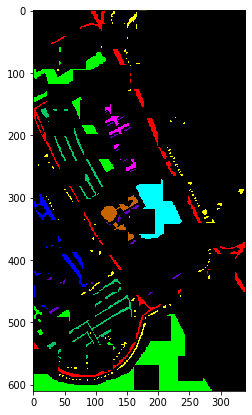

In [24]:
ground_truth = spectral.imshow(classes = y, figsize =(7,7))

In [25]:
#TU JEST ZAHARDCODOWANA ILOSC KLAS. można zrobić count(unique(labels)) albo max(labels)
classes_in_test_squares = countClassesInLabelSquares(1 + 9, testSquares_GT, 12) # 16 classes + 1 for bacground
classes_in_train_set = countClassesInGt(1 + 9, y)
#brakuje takich samych danych dla treningowego
classes_in_test_squares, classes_in_train_set

(array([13841.,   426.,  1187.,    58.,   198.,    56.,   256.,    74.,
          220.,    68.]),
 array([182574.,   3801.,  11162.,   1213.,   1478.,    631.,   3028.,
           947.,   2075.,    491.]))

In [26]:
classes_in_squares_count = np.sum(classes_in_test_squares[1 : classes_in_test_squares.shape[0]])
testSet, testSetLabels, testSet_GT = convertSquaresToTestSets(testSquares, testSquares_GT, windowSize, classes_in_squares_count)

In [27]:
trainSet, trainSetLabels = createImageCubes(X, y, windowSize=windowSize)

trainSet.shape, trainSetLabels.shape

((24826, 25, 25, 15), (24826,))

In [28]:
trainSet.shape, testSet.shape, trainSetLabels.shape, testSetLabels.shape

((24826, 25, 25, 15), (2543, 25, 25, 15), (24826,), (2543,))

In [29]:
#just to not rename everything in notebook
Xtrain = trainSet
Xtest = testSet
ytrain = trainSetLabels - 1
ytest = testSetLabels - 1

In [30]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((24826, 25, 25, 15), (2543, 25, 25, 15), (24826,), (2543,))

# Model and Training

In [31]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(24826, 25, 25, 15, 1)

In [32]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(24826, 9)

In [33]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [34]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 15, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 17, 17, 1, 64)     55360     
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4735232   
__________

In [37]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [38]:
# checkpoint
filepath = "best-model-3D.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [39]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=5, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
24826/24826 [==============================] - 44s 2ms/step - loss: 0.5978 - acc: 0.7904

Epoch 00001: acc improved from -inf to 0.79042, saving model to best-model-3D.hdf5
Epoch 2/5
24826/24826 [==============================] - 39s 2ms/step - loss: 0.0330 - acc: 0.9906

Epoch 00002: acc improved from 0.79042 to 0.99061, saving model to best-model-3D.hdf5
Epoch 3/5
24826/24826 [==============================] - 39s 2ms/step - loss: 0.0146 - acc: 0.9957

Epoch 00003: acc improved from 0.99061 to 0.99573, saving model to best-model-3D.hdf5
Epoch 4/5
24826/24826 [==============================] - 39s 2ms/step - loss: 0.0075 - acc: 0.9978

Epoch 00004: acc improved from 0.99573 to 0.99782, saving model to best-model-3D.hdf5
Epoch 5/5
24826/24826 [==============================] - 39s 2ms/step - loss: 0.0033 - acc: 0.9990

Epoch 00005: acc improved from 0.99782 to 0.99899, saving model to best-model-3D.hdf5


# Validation

In [40]:
# load best weights
model.load_weights("best-model-3D.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [41]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(2543, 25, 25, 15, 1)

In [42]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(2543, 9)

In [43]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       426
           1       1.00      1.00      1.00      1187
           2       0.92      0.81      0.86        58
           3       0.97      0.93      0.95       198
           4       1.00      1.00      1.00        56
           5       1.00      1.00      1.00       256
           6       0.97      1.00      0.99        74
           7       0.89      1.00      0.94       220
           8       1.00      0.72      0.84        68

    accuracy                           0.98      2543
   macro avg       0.97      0.94      0.95      2543
weighted avg       0.98      0.98      0.98      2543



In [44]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [45]:
# load the original image
X, y = loadData(dataset)

In [46]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [47]:
X,pca = applyPCA(X, numComponents=numComponents)

In [48]:
X = padWithZeros(X, PATCH_SIZE//2)

In [46]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

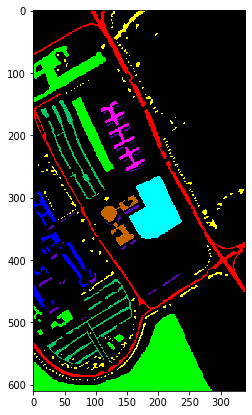

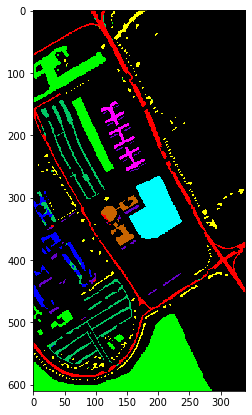

In [47]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [36]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)